In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
df = pd.read_csv('Ecommerce_Sales_Prediction_Dataset.csv')
df.head()

,Date,Product_Category,Price,Discount,Customer_Segment,Marketing_Spend,Units_Sold
0,01-01-2023,Sports,932.80,35.82,Occasional,6780.38,32
1,02-01-2023,Toys,569.48,3.60,Premium,6807.56,16
2,03-01-2023,Home Decor,699.68,3.56,Premium,3793.91,27
3,04-01-2023,Toys,923.27,0.61,Premium,9422.75,29
4,05-01-2023,Toys,710.17,47.83,Premium,1756.83,17


In [7]:
profit = df['Price']*df['Units_Sold'] - df['Marketing_Spend']
df['Profit'] = profit
df.head()


,Date,Product_Category,Price,Discount,Customer_Segment,Marketing_Spend,Units_Sold,Profit
0,01-01-2023,Sports,932.80,35.82,Occasional,6780.38,32,23069.22
1,02-01-2023,Toys,569.48,3.60,Premium,6807.56,16,2304.12
2,03-01-2023,Home Decor,699.68,3.56,Premium,3793.91,27,15097.45
3,04-01-2023,Toys,923.27,0.61,Premium,9422.75,29,17352.08
4,05-01-2023,Toys,710.17,47.83,Premium,1756.83,17,10316.06


In [8]:
df.describe()

,Price,Discount,Marketing_Spend,Units_Sold,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,505.241920,24.919750,4912.830240,29.631000,10089.654320
std,289.791248,14.439951,2840.602656,7.267989,9986.936821
min,14.590000,0.010000,100.300000,5.000000,-9190.000000
25%,243.342500,12.995000,2413.020000,24.000000,1907.505000
50%,509.310000,24.965000,4837.245000,30.000000,9111.160000
75%,747.592500,37.562500,7319.675000,34.000000,17193.945000
max,999.420000,49.920000,9995.620000,57.000000,45024.380000


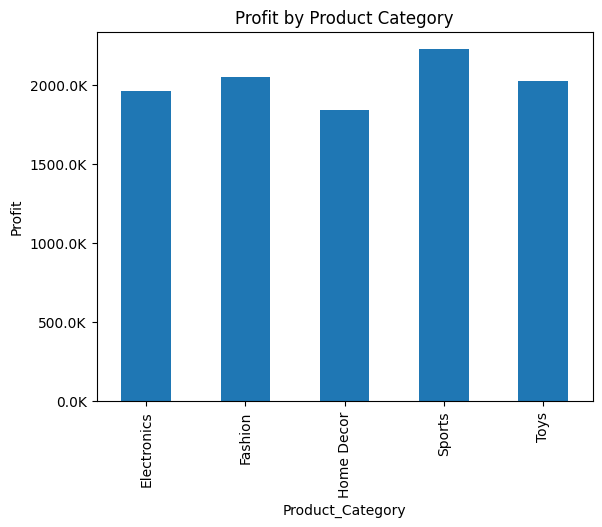

In [9]:
from matplotlib.ticker import FuncFormatter

# Function to format the y-axis labels
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatter = FuncFormatter(thousands)

# Plot profit with product category adding profits of same product category together
ax = df.groupby('Product_Category')['Profit'].sum().plot(kind='bar')
ax.yaxis.set_major_formatter(formatter)
plt.ylabel('Profit')
plt.title('Profit by Product Category')
plt.show()

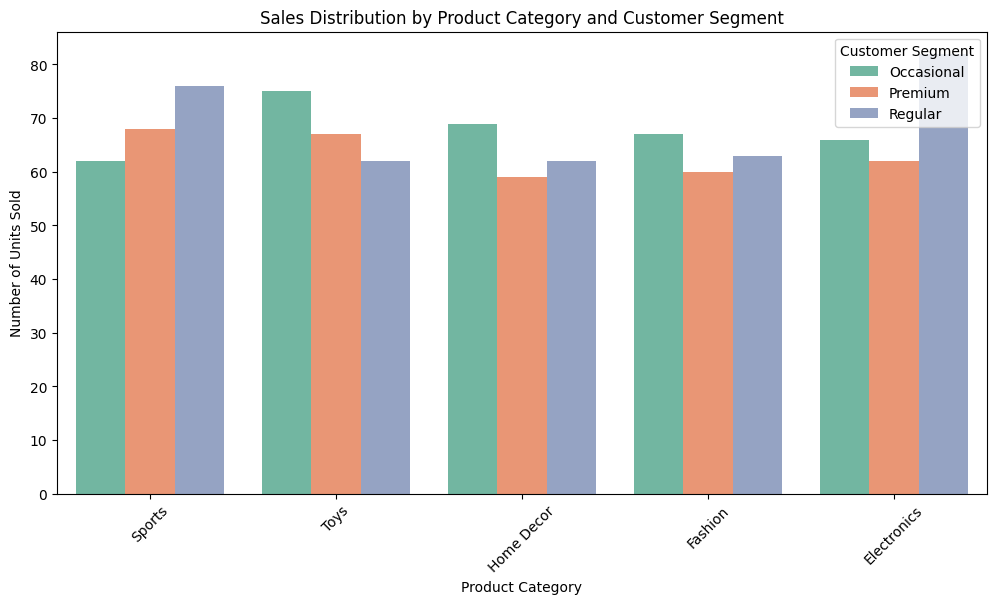

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Product_Category', hue='Customer_Segment', palette='Set2')
plt.title('Sales Distribution by Product Category and Customer Segment')
plt.xlabel('Product Category')
plt.ylabel('Number of Units Sold')
plt.xticks(rotation=45)
plt.legend(title='Customer Segment')
plt.show()

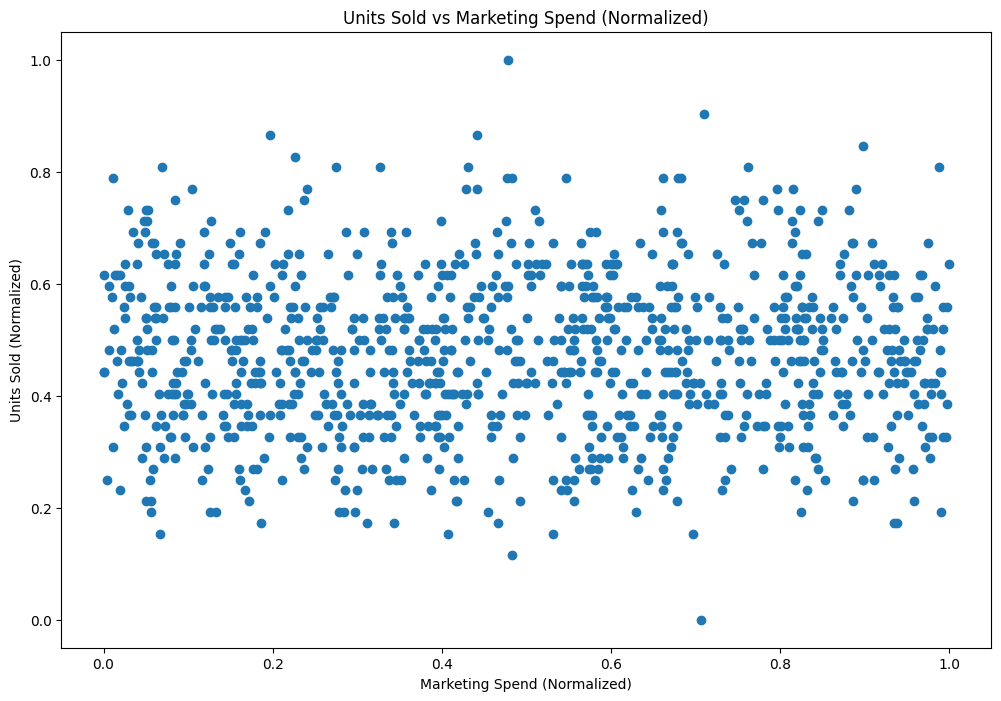

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the data
units_sold_scaled = scaler.fit_transform(df[['Units_Sold']])
marketing_spend_scaled = scaler.fit_transform(df[['Marketing_Spend']])

# Increase the size of the graph
plt.figure(figsize=(12, 8))

# Plot the scatter plot with normalized data and smaller points
plt.scatter(marketing_spend_scaled, units_sold_scaled)
plt.ylabel('Units Sold (Normalized)')
plt.xlabel('Marketing Spend (Normalized)')
plt.title('Units Sold vs Marketing Spend (Normalized)')
plt.show()


c:\Users\siddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error: 57.83020552972824


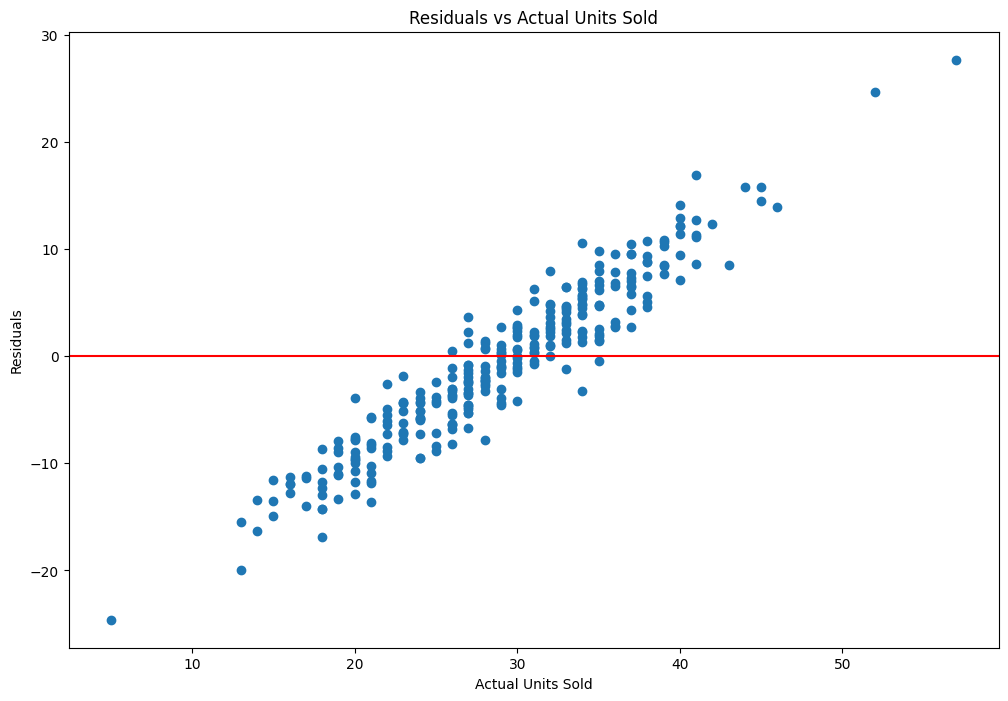

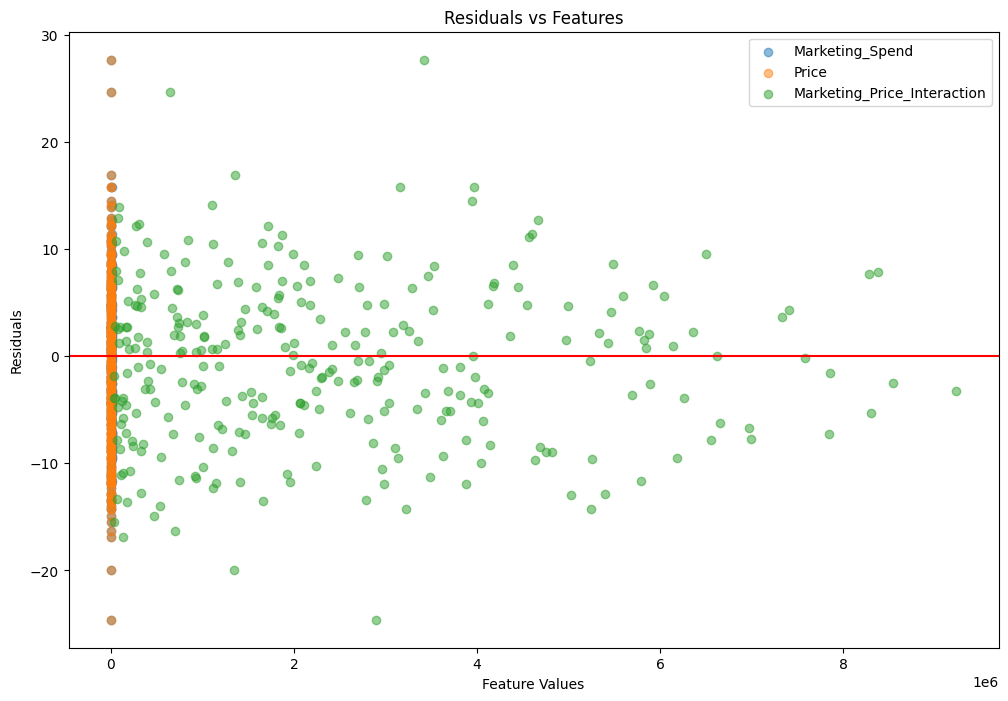

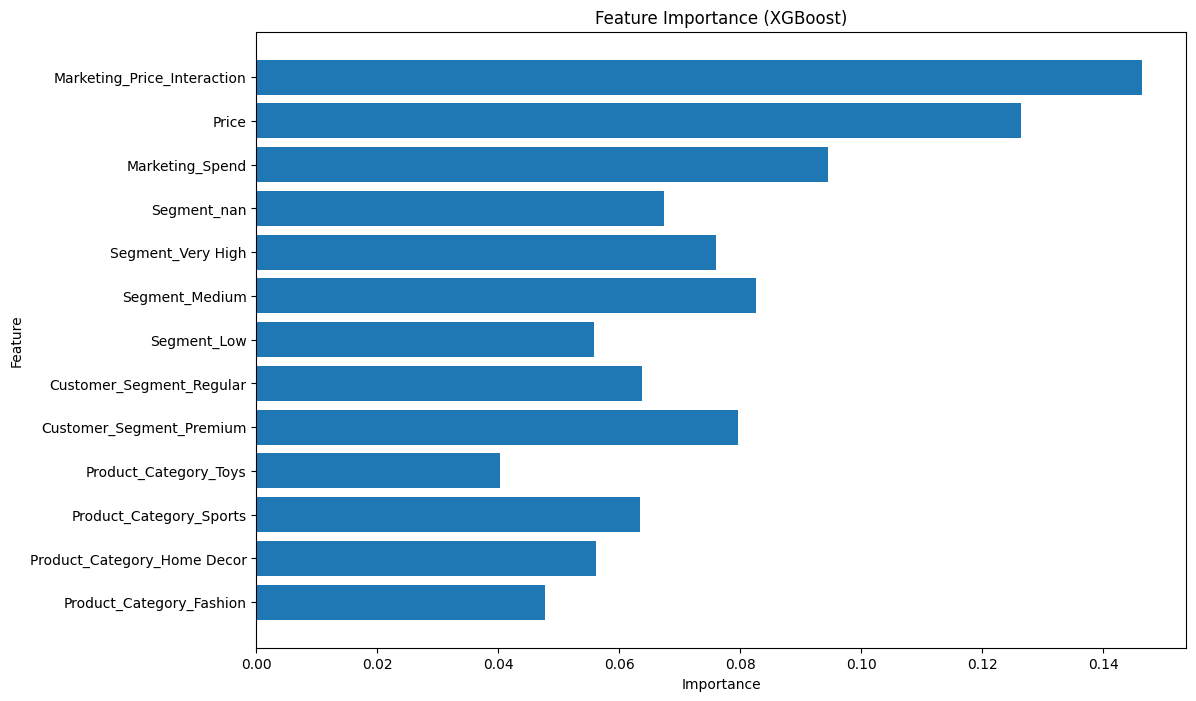

In [12]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Add interaction features and segmentation
df['Marketing_Price_Interaction'] = df['Marketing_Spend'] * df['Price']
df['Segment'] = pd.cut(df['Price'], bins=[0, 50, 100, 150, 200], labels=['Low', 'Medium', 'High', 'Very High'])

# Define features and target
X = df[['Marketing_Spend', 'Product_Category', 'Price', 'Customer_Segment', 'Marketing_Price_Interaction', 'Segment']]
y = df['Units_Sold']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define columns for preprocessing
categorical_columns = ['Product_Category', 'Customer_Segment', 'Segment']
numerical_columns = ['Marketing_Spend', 'Price', 'Marketing_Price_Interaction']

# Preprocessors
encoder = OneHotEncoder(drop='first')
scaler = StandardScaler()

column_transformer = ColumnTransformer([
    ('encoder', encoder, categorical_columns),
    ('scaler', scaler, numerical_columns)
])

# Define individual models
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=0, n_estimators=500, max_depth=7, learning_rate=0.05)
rf_model = RandomForestRegressor(random_state=0, n_estimators=200, max_depth=10)
nn_model = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500, random_state=0)

# Voting Regressor (ensemble model)
ensemble_model = VotingRegressor(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('nn', nn_model)
])

# Pipeline for preprocessing and ensemble
pipeline = Pipeline([('preprocessor', column_transformer), ('model', ensemble_model)])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Residual plot against actual
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_test - y_pred)
plt.axhline(0, color='red')
plt.xlabel('Actual Units Sold')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Units Sold')
plt.show()

# Residuals vs Features
plt.figure(figsize=(12, 8))
for feature in numerical_columns:
    plt.scatter(X_test[feature], y_test - y_pred, alpha=0.5, label=feature)
plt.axhline(0, color='red')
plt.xlabel('Feature Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Features')
plt.legend()
plt.show()

# Feature importance from XGBoost
xgb_model.fit(column_transformer.transform(X_train), y_train)
importances = xgb_model.feature_importances_
features = column_transformer.transformers_[0][1].get_feature_names_out(categorical_columns).tolist() + numerical_columns
plt.figure(figsize=(12, 8))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost)')
plt.show()


Index(['Date', 'Product_Category', 'Customer_Segment'], dtype='object')
X_train_transformed shape: (700, 15)
X_test_transformed shape: (300, 15)


c:\Users\siddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn(
c:\Users\siddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\siddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\siddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individ

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 934.6892 - val_loss: 730.9691
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 663.7507 - val_loss: 335.8729
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 243.6647 - val_loss: 75.3847
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 80.0989 - val_loss: 33.3810
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 41.0214 - val_loss: 24.6246
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 38.7797 - val_loss: 20.4368
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 32.3232 - val_loss: 19.0789
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 32.2959 - val_loss: 17.6974
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27.8510 - val_loss: 16.6504
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28.1103 - val_loss: 17.3915
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27.2368 - val_loss: 15.2206
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

[I 2024-12-29 01:52:18,884] A new study created in memory with name: no-name-85f68b3d-b2af-4792-9291-da6047fc2900
[I 2024-12-29 01:52:19,050] Trial 0 finished with value: 2.224771607427914 and parameters: {'n_estimators': 120, 'max_depth': 8, 'learning_rate': 0.15133629164037193, 'subsample': 0.7293584022713511, 'colsample_bytree': 0.5479187091536774}. Best is trial 0 with value: 2.224771607427914.


Mean Squared Error after Residual Modeling: 0.4982716461500634


[I 2024-12-29 01:52:19,497] Trial 1 finished with value: 2.4427131374702884 and parameters: {'n_estimators': 447, 'max_depth': 11, 'learning_rate': 0.15351707349483779, 'subsample': 0.8930483651835813, 'colsample_bytree': 0.8610879494053914}. Best is trial 0 with value: 2.224771607427914.
[I 2024-12-29 01:52:19,628] Trial 2 finished with value: 1.100305917560551 and parameters: {'n_estimators': 167, 'max_depth': 5, 'learning_rate': 0.20497305438451296, 'subsample': 0.9516509145221528, 'colsample_bytree': 0.7077826477835916}. Best is trial 2 with value: 1.100305917560551.
[I 2024-12-29 01:52:20,292] Trial 3 finished with value: 1.6900652766279352 and parameters: {'n_estimators': 821, 'max_depth': 11, 'learning_rate': 0.08693119946140955, 'subsample': 0.8257514994561299, 'colsample_bytree': 0.8607557147091707}. Best is trial 2 with value: 1.100305917560551.
[I 2024-12-29 01:52:20,742] Trial 4 finished with value: 7.02275147860911 and parameters: {'n_estimators': 193, 'max_depth': 15, 'le

Best Parameters: {'n_estimators': 845, 'max_depth': 3, 'learning_rate': 0.08098309287988764, 'subsample': 0.6804665539191188, 'colsample_bytree': 0.999760143297753}
Mean Squared Error after Optuna Optimization: 0.3369121277466002


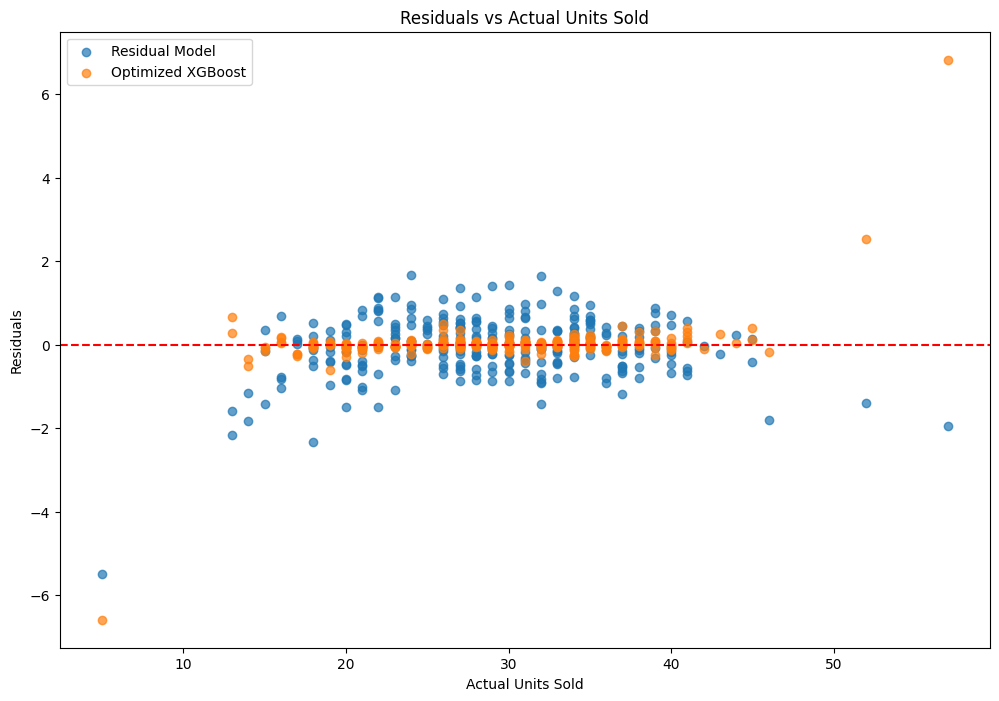

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import optuna
import featuretools as ft

# Example DataFrame (replace this with your actual data)
# df = pd.read_csv('your_dataset.csv')  # Ensure you load your data correctly

# Check for non-numeric columns that should be categorical
print(df.select_dtypes(include=['object']).columns)

# Generate interaction features
df['Marketing_Price_Interaction'] = df['Marketing_Spend'] * df['Price']
df['Segment'] = pd.cut(df['Price'], bins=[0, 250, 500, 750, 1000], labels=['Low', 'Medium', 'High', 'Very High'])



# Feature Engineering with FeatureTools
es = ft.EntitySet(id="sales_data")
es.add_dataframe(dataframe_name="data", dataframe=df, index="index")

# Generate features with FeatureTools
feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name="data", max_depth=2)
X = feature_matrix  # Use all generated features
y = df['Units_Sold']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Ensure categorical columns are encoded and numerical columns are scaled
categorical_features = ['Product_Category', 'Customer_Segment', 'Segment']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Preprocessing Pipeline
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
scaler = StandardScaler()

# Create ColumnTransformer
column_transformer = ColumnTransformer([
    ('encoder', encoder, categorical_features),
    ('scaler', scaler, numerical_features)
], remainder='drop')

# Apply transformations to the training and test data
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

# Ensure that the transformed data has been processed correctly
print(f"X_train_transformed shape: {X_train_transformed.shape}")
print(f"X_test_transformed shape: {X_test_transformed.shape}")

# Step 1: Neural Network Model
def build_nn_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train the neural network with the transformed data
nn_model = build_nn_model(X_train_transformed.shape[1])
nn_model.fit(X_train_transformed, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)
y_pred_nn = nn_model.predict(X_test_transformed).flatten()

# Step 2: Residual Modeling
residuals = y_train - nn_model.predict(X_train_transformed).flatten()
residual_model = XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=5)
residual_model.fit(X_train_transformed, residuals)

# Final predictions with residual correction
residual_corrections = residual_model.predict(X_test_transformed)
final_predictions = y_pred_nn + residual_corrections

# Evaluate the residual model
mse_residual = mean_squared_error(y_test, final_predictions)
print("Mean Squared Error after Residual Modeling:", mse_residual)

# Step 3: Hyperparameter Optimization with Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = XGBRegressor(**params, objective='reg:squarederror')
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    return mean_squared_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)

# Train XGBoost with optimized parameters
best_model = XGBRegressor(**study.best_params, objective='reg:squarederror')
best_model.fit(X_train_transformed, y_train)
y_pred_optuna = best_model.predict(X_test_transformed)

# Final evaluation
mse_optuna = mean_squared_error(y_test, y_pred_optuna)
print("Mean Squared Error after Optuna Optimization:", mse_optuna)

# Plot residuals
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_test - final_predictions, label='Residual Model', alpha=0.7)
plt.scatter(y_test, y_test - y_pred_optuna, label='Optimized XGBoost', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Units Sold')
plt.ylabel('Residuals')
plt.legend()
plt.title('Residuals vs Actual Units Sold')
plt.show()




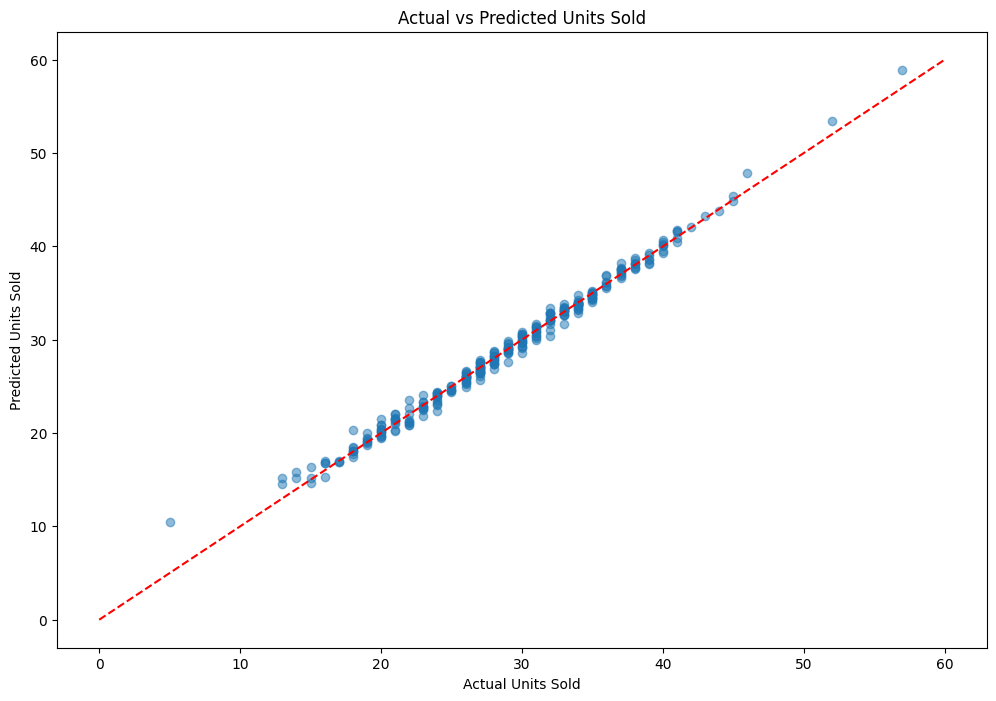

In [16]:
#plot a graph between actual units sold and predicted units sold
plt.figure(figsize=(12, 8))
plt.scatter(y_test, final_predictions, alpha=0.5)
plt.plot([0, 60], [0, 60], color='red', linestyle='--')
plt.xlabel('Actual Units Sold')
plt.ylabel('Predicted Units Sold')
plt.title('Actual vs Predicted Units Sold')
plt.show()




In [54]:
from sklearn.metrics import r2_score

# Additional evaluation metrics
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    r2 = r2_score(y_true, y_pred)
    
    print("Evaluation Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.2f}%")
    print(f"R-squared (R2): {r2:.4f}")
    return mape, smape, r2

# Evaluate the final residual model predictions
print("Residual Model Evaluation:")
evaluate_model(y_test, final_predictions)

# Evaluate the optimized XGBoost model predictions
print("\nOptimized XGBoost Model Evaluation:")
evaluate_model(y_test, y_pred_optuna)


Residual Model Evaluation:
Evaluation Metrics:
Mean Squared Error (MSE): 0.4621
Root Mean Squared Error (RMSE): 0.6798
Mean Absolute Error (MAE): 0.5005
Mean Absolute Percentage Error (MAPE): 2.15%
Symmetric Mean Absolute Percentage Error (sMAPE): 2.07%
R-squared (R2): 0.9913

Optimized XGBoost Model Evaluation:
Evaluation Metrics:
Mean Squared Error (MSE): 0.4047
Root Mean Squared Error (RMSE): 0.6362
Mean Absolute Error (MAE): 0.2044
Mean Absolute Percentage Error (MAPE): 1.05%
Symmetric Mean Absolute Percentage Error (sMAPE): 0.89%
R-squared (R2): 0.9924


(1.0534570227790423, 0.8861276893564634, 0.9924043416976929)

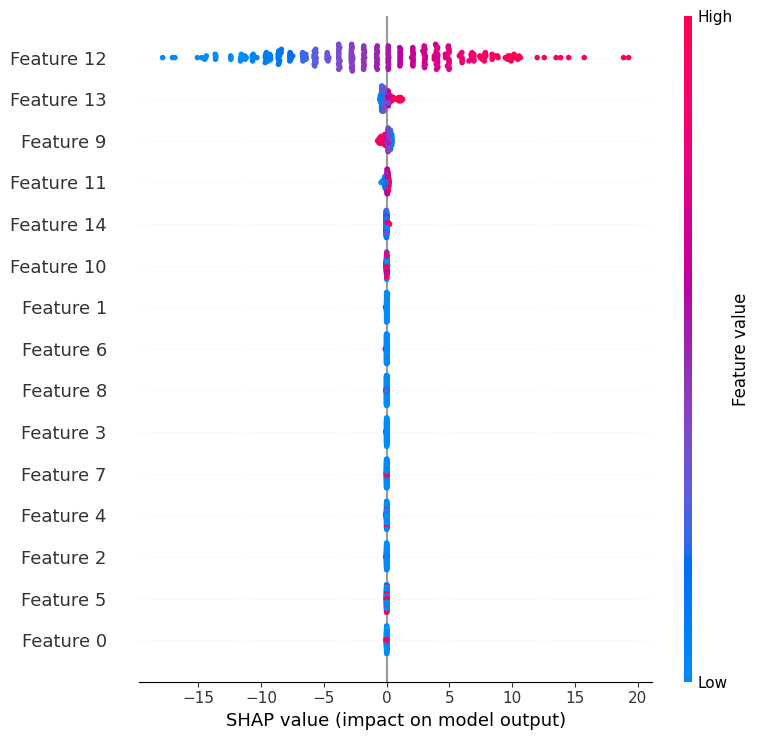

In [17]:
# Cell 6: Explain Predictions with SHAP
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_transformed)

# Plot summary plot for SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_transformed)
